In [71]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

filename='/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv'
df=pd.read_csv(filename)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv


In [79]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [80]:
from scipy import stats
z = np.abs(stats.zscore(df))
print(z)

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0          0.528360          0.961877     1.391472        0.453218   0.243707   
1          0.298547          1.967442     1.391472        0.043416   0.223875   
2          0.298547          1.297065     1.186070        0.169427   0.096353   
3          1.654856          1.384443     1.484154        0.453218   0.264960   
4          0.528360          0.961877     1.391472        0.453218   0.243707   
...             ...               ...          ...             ...        ...   
1594       1.217796          0.403229     0.980669        0.382271   0.053845   
1595       1.390155          0.123905     0.877968        0.240375   0.541259   
1596       1.160343          0.099554     0.723916        0.169427   0.243707   
1597       1.390155          0.654620     0.775267        0.382271   0.264960   
1598       1.332702          1.216849     1.021999        0.752894   0.434990   

      free sulfur dioxide  

In [81]:
threshold = 3
print(np.where(z > 3))


(array([  13,   14,   15,   15,   17,   17,   19,   33,   38,   42,   43,
         45,   57,   81,   81,   83,   86,   88,   91,   92,   95,  106,
        106,  109,  120,  126,  127,  142,  144,  147,  151,  151,  151,
        151,  163,  164,  169,  169,  181,  199,  226,  226,  240,  243,
        244,  258,  258,  274,  281,  291,  324,  325,  339,  340,  347,
        354,  374,  381,  391,  396,  396,  400,  400,  442,  442,  451,
        459,  467,  480,  480,  494,  515,  517,  544,  554,  554,  555,
        555,  557,  557,  568,  584,  588,  591,  595,  608,  614,  636,
        639,  649,  649,  651,  652,  652,  652,  672,  672,  684,  690,
        690,  692,  692,  695,  723,  724,  730,  754,  776,  777,  795,
        821,  832,  836,  837,  889,  899,  911,  917,  923,  925,  926,
        982, 1017, 1018, 1043, 1051, 1051, 1071, 1074, 1079, 1079, 1081,
       1081, 1111, 1114, 1131, 1154, 1165, 1175, 1186, 1231, 1235, 1244,
       1244, 1244, 1260, 1269, 1269, 1270, 1270, 1

In [82]:
df = df[(z < 3).all(axis=1)]

In [83]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [84]:
df['quality'].apply(lambda y_value: 1 if y_value>=7 else 0)
X=df.loc[ : , df.columns != 'quality'].values
y=df['quality'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


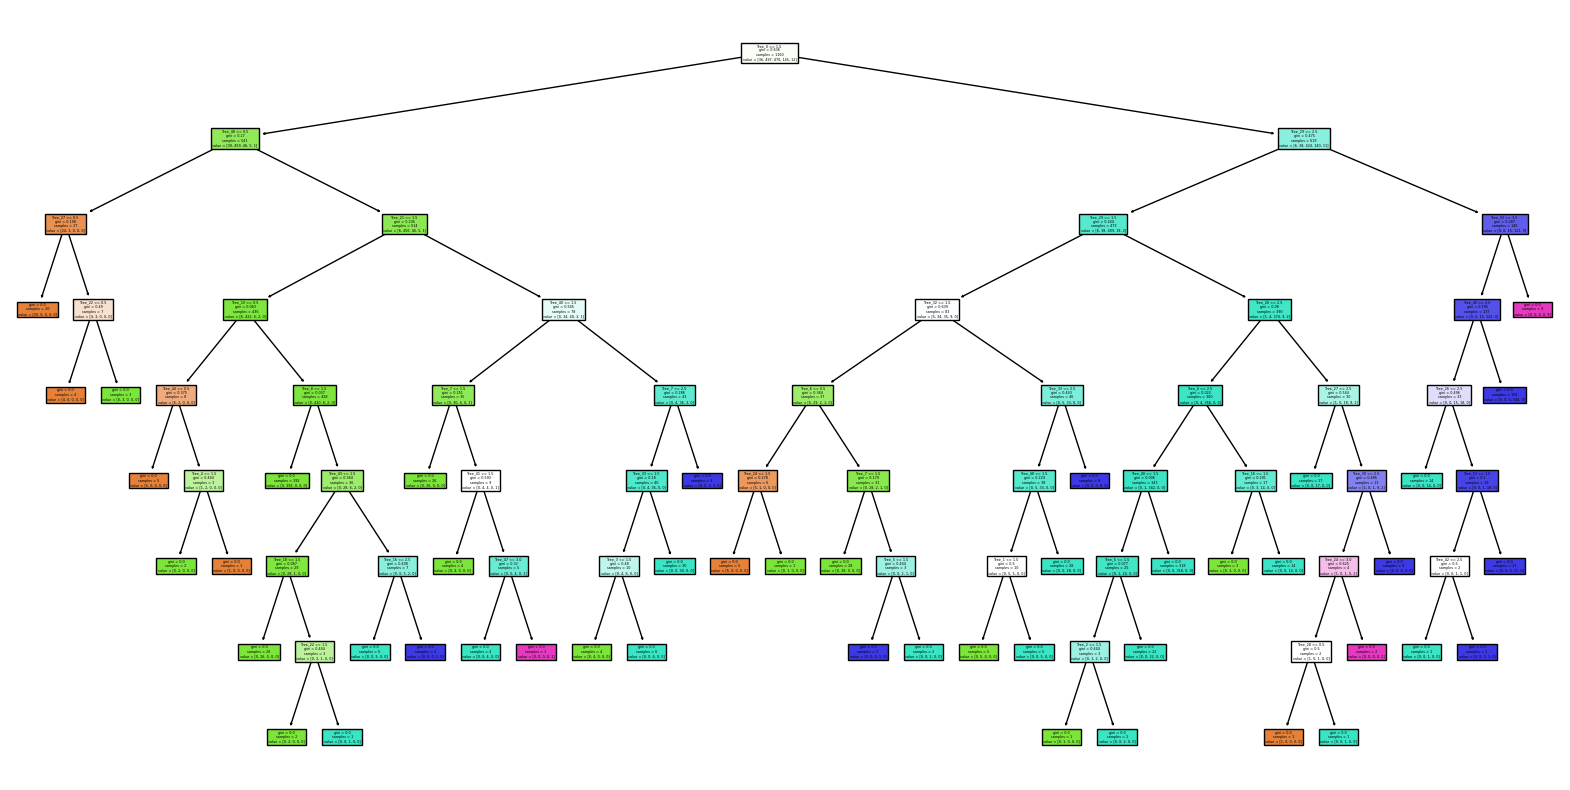

Decision Tree:
|--- Tree_0 <= 1.50
|   |--- Tree_48 <= 0.50
|   |   |--- Tree_27 <= 0.50
|   |   |   |--- class: 4
|   |   |--- Tree_27 >  0.50
|   |   |   |--- Tree_22 <= 0.50
|   |   |   |   |--- class: 4
|   |   |   |--- Tree_22 >  0.50
|   |   |   |   |--- class: 5
|   |--- Tree_48 >  0.50
|   |   |--- Tree_21 <= 1.50
|   |   |   |--- Tree_10 <= 0.50
|   |   |   |   |--- Tree_44 <= 0.50
|   |   |   |   |   |--- class: 4
|   |   |   |   |--- Tree_44 >  0.50
|   |   |   |   |   |--- Tree_4 <= 1.50
|   |   |   |   |   |   |--- class: 5
|   |   |   |   |   |--- Tree_4 >  1.50
|   |   |   |   |   |   |--- class: 4
|   |   |   |--- Tree_10 >  0.50
|   |   |   |   |--- Tree_8 <= 1.50
|   |   |   |   |   |--- class: 5
|   |   |   |   |--- Tree_8 >  1.50
|   |   |   |   |   |--- Tree_43 <= 1.50
|   |   |   |   |   |   |--- Tree_18 <= 1.50
|   |   |   |   |   |   |   |--- class: 5
|   |   |   |   |   |   |--- Tree_18 >  1.50
|   |   |   |   |   |   |   |--- Tree_22 <= 1.50
|   |   |   |   | 

In [85]:
base_clf=DecisionTreeClassifier()

bagging_clf=BaggingClassifier(base_estimator=base_clf,n_estimators=50, random_state=42)
bagging_clf.fit(X_train, y_train)

feature_names = df.columns[df.columns !='quality']
class_names=list(df['quality'].unique())

aggregate_predictions = np.zeros((len(X_train), len(bagging_clf.estimators_)))
for i, tree in enumerate(bagging_clf.estimators_):
    aggregate_predictions[:, i] = tree.predict(X_train)


final_tree = DecisionTreeClassifier()
final_tree.fit(aggregate_predictions, y_train)

plt.figure(figsize=(20, 10))
plot_tree(final_tree, feature_names=[f"Tree_{i}" for i in range(len(bagging_clf.estimators_))], filled=True)
plt.show()

tree_text = export_text(final_tree, feature_names=[f"Tree_{i}" for i in range(len(bagging_clf.estimators_))])
print("Decision Tree:")
print(tree_text)

In [86]:
y_pred = bagging_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of BaggingClassifier: {accuracy:.2f}')

Accuracy of BaggingClassifier: 0.64


In [87]:
## random forest

from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)

Accuracy: 0.6838487972508591


In [88]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [89]:
import pandas as pd
feature_imp = pd.Series(rf_classifier.feature_importances_, index=df.columns[:11]).sort_values(ascending=False)
feature_imp

alcohol                 0.157697
sulphates               0.117674
total sulfur dioxide    0.102118
volatile acidity        0.092555
density                 0.091228
chlorides               0.079790
fixed acidity           0.076994
citric acid             0.075347
pH                      0.073030
residual sugar          0.069053
free sulfur dioxide     0.064514
dtype: float64

In [90]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter distributions
param_dist = {
    'n_estimators':  [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'max_depth': [int(x) for x in np.linspace(2, 14, num = 7)],
    'min_samples_split': [2, 5, 10] ,
    'min_samples_leaf': [1, 2, 4] ,
    'max_features': ['sqrt', 'log2']
}

random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_dist, n_iter=100, cv=3, random_state=42, scoring='accuracy', n_jobs=-1)
random_search.fit(X_train, y_train)


best_params = random_search.best_params_


In [91]:
best_params

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 14}

In [92]:
rf_classifier = RandomForestClassifier(**best_params)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)

Accuracy: 0.6563573883161512


In [ ]:
from sklearn.model_selection import GridSearchCV


param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20],       # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],     # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2'],  # Number of features to consider when looking for the best split
}


rf_classifier = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)


grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

In [ ]:
best_params

In [ ]:
rf_classifier = RandomForestClassifier(**best_params,random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)